In [1]:
#| default_exp imgaug_loader

In [2]:
#| export
#| hide
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from torch_snippets.loader import BB, PIL, bbs2df, df2bbs, np, pd, Image
from torch_snippets.bb_utils import split_bb_to_xyXY, combine_xyXY_to_bb, to_relative, to_absolute

/data1/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
#| export
#| hide
def do(img, bbs, aug, cval=255):
    if isinstance(img, PIL.Image.Image):
        _Image = True
        img = np.array(img)
    else:
        _Image = False
    H, W = img.shape[:2]
    if isinstance(bbs, pd.DataFrame):
        _df = bbs.copy()
        _separate = True if 'x' in _df.columns else False
        if not _separate:
            _df = split_bb_to_xyXY(_df)
        _relative = True if _df['x'].max() < 1 else False
        if _relative:
            _df = to_absolute(_df, H, W)
        bbs = df2bbs(_df)
        remaining_columns = [c for c in _df.columns if c not in 'xyXY']
        __df = _df[remaining_columns]
        _data_frame = True
    else:
        _data_frame = False

    bbs = bbs2imgaugbbs(bbs, img)
    img, bbs = aug(images=[img], bounding_boxes=[bbs])
    img, bbs = (img[0], imgaugbbs2bbs(bbs))
    H, W = img.shape[:2]
    
    if _Image:
        img = Image.fromarray(img)
    if _data_frame:
        _df = bbs2df(bbs)
        __df[[*'xyXY']] = _df.values
        if _relative:
            __df = to_relative(__df, H, W)
        if not _separate:
            __df = combine_xyXY_to_bb(__df)
        bbs = __df
    return img, bbs


def bw(img, bbs):
    aug = iaa.Grayscale()
    return do(img, bbs, aug)


def rotate(img, bbs, angle, cval=255):
    aug = iaa.Rotate(angle, cval=cval, fit_output=True)
    return do(img, bbs, aug)


def pad(img, bbs, sz=None, deltas=None, cval=0):
    if isinstance(img, np.ndarray):
        h, w = img.shape[:2]
    else:
        w, h = img.size
    if sz:
        H, W = sz
        deltas = (H - h) // 2, (W - w) // 2, (H - h) // 2, (W - w) // 2

    aug = iaa.Pad(deltas, pad_cval=cval)
    return do(img, bbs, aug)

def get_size(sz, h, w):
    if isinstance(sz, (tuple, list)) and isinstance(sz[0], str):
        signal, (H, W) = sz
        assert signal in "at-least,at-most".split(
            ","
        ), "Resize type must be one of `at-least` or `at-most`"
        if signal == "at-least":
            f = max(H / h, W / w)
        if signal == "at-most":
            f = min(H / h, W / w)
        H, W = [i * f for i in [h, w]]
    elif isinstance(sz, float):
        frac = sz
        H, W = [i * frac for i in [h, w]]
    elif isinstance(sz, int):
        H, W = sz, sz
    elif isinstance(sz, tuple):
        H, W = sz
        if H == -1:
            _, W = sz
            f = W / w
            H = f * h
        elif W == -1:
            H, _ = sz
            f = H / h
            W = f * w
        elif isinstance(H, float):
            H = H * h
        elif isinstance(W, float):
            W = W * h
    H, W = int(H), int(W)
    return H, W

def rescale(im, bbs, sz):
    if isinstance(im, PIL.Image.Image):
        to_pil = True
        im = np.array(im)
    else:
        to_pil = False
    h, w = im.shape[:2]
    H, W = get_size(sz, h, w)
    aug = iaa.Resize({"height": H, "width": W})
    im, bbs = do(im, bbs, aug)
    if to_pil:
        im = PIL.Image.fromarray(im)
    return im, bbs


def crop(img, bbs, deltas):
    aug = iaa.Crop(deltas)
    return do(img, bbs, aug)


def imgaugbbs2bbs(bbs):
    if bbs is None:
        return None
    return [
        BB([int(i) for i in (bb.x1, bb.y1, bb.x2, bb.y2)])
        for bb in bbs[0].bounding_boxes
    ]


def bbs2imgaugbbs(bbs, img):
    if bbs is None:
        return None
    return BoundingBoxesOnImage(
        [BoundingBox(x1=x, y1=y, x2=X, y2=Y) for x, y, X, Y in bbs], shape=img.shape
    )

In [4]:
from torch_snippets.loader import read, pd, show
IM = read('/data1/yeshwanth/torch_snippets/assets/Preamble.png')
DF = pd.read_csv('/data1/yeshwanth/torch_snippets/assets/Preamble.csv')
DF = to_relative(DF, *IM.shape[:2])
DF.head()

x         y         X         Y         text  block_id
0  0.249538  0.253501  0.569316  0.305322  ConstITUtIO         0
1  0.288355  0.369748  0.401109  0.397759        NLTHE         1
2  0.402957  0.369748  0.510166  0.397759       PEOPLE         1
3  0.493530  0.371148  0.545287  0.394958           OF         1
4  0.548983  0.369748  0.630314  0.397759       INDIA,         1

## Rescale

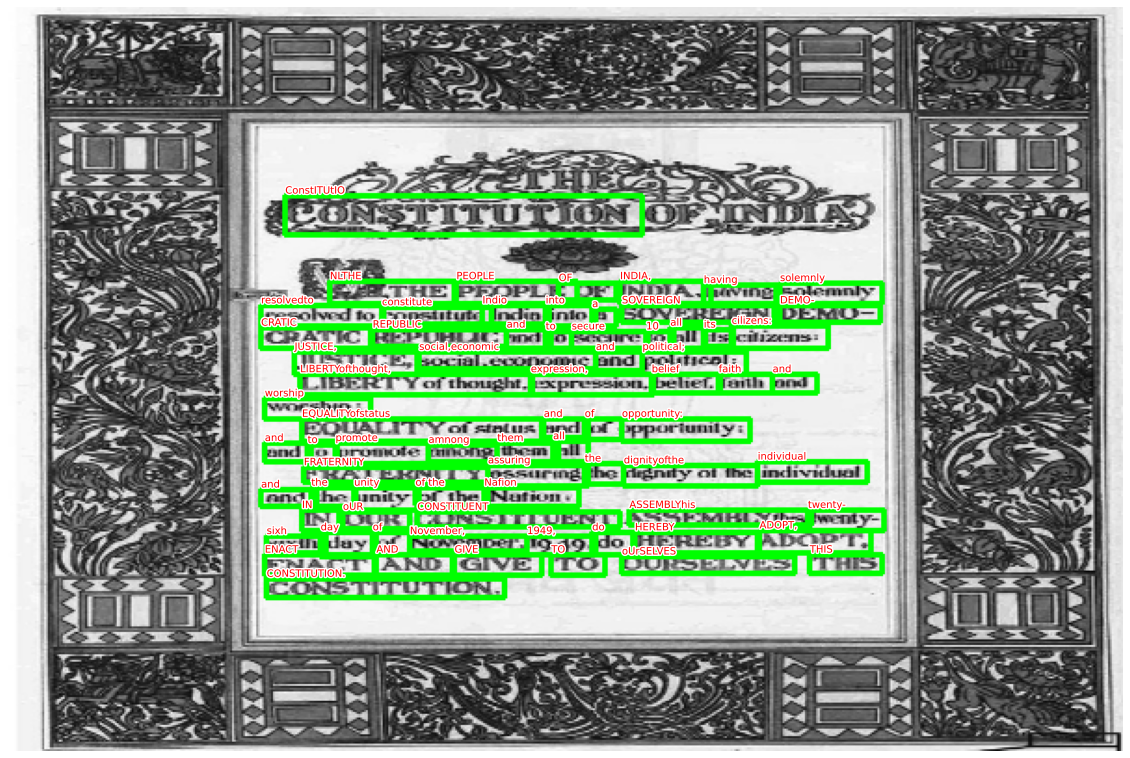

text  block_id         x       y         X       Y
0  ConstITUtIO         0  0.248333  0.2525  0.568333  0.3050
1        NLTHE         1  0.288333  0.3675  0.400000  0.3975
2       PEOPLE         1  0.401667  0.3675  0.510000  0.3975
3           OF         1  0.493333  0.3700  0.545000  0.3925
4       INDIA,         1  0.548333  0.3675  0.630000  0.3975

In [9]:
df = DF.copy()
im = IM.copy()
im, df = rescale(im, df, (400, 600))
show(im, df=df, sz=20)
df.head()

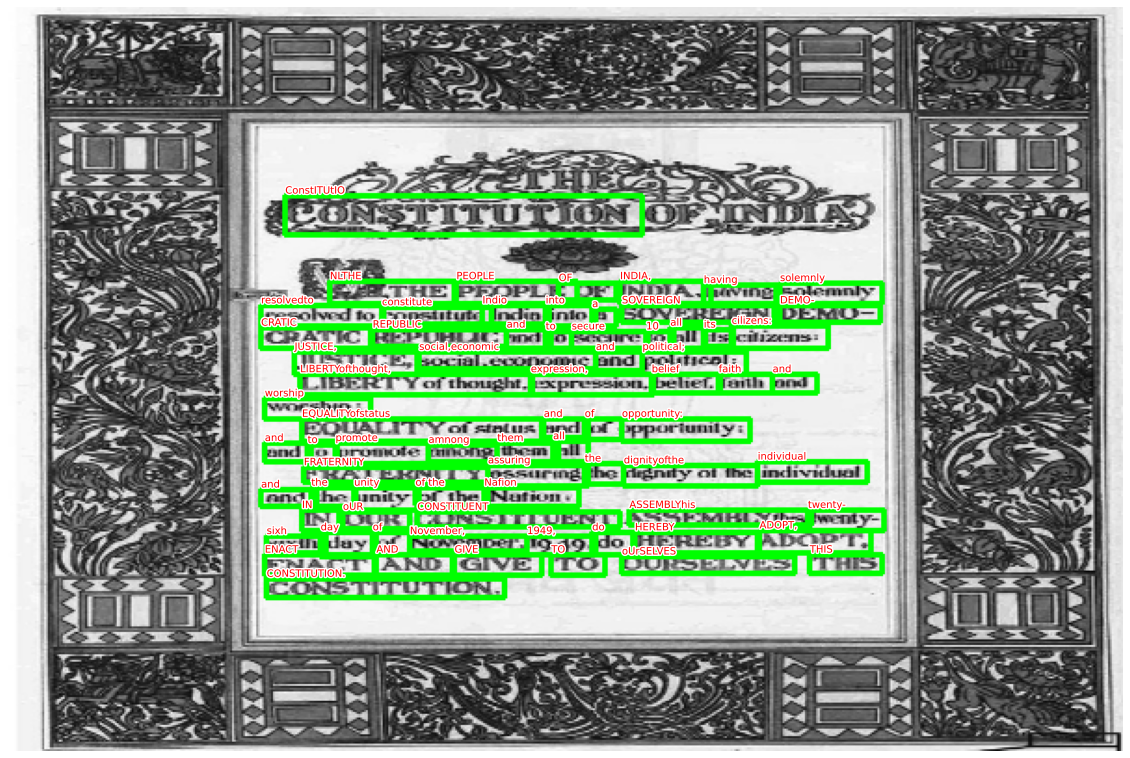

text  block_id    x    y    X    Y
0  ConstITUtIO         0  149  101  341  122
1        NLTHE         1  173  147  240  159
2       PEOPLE         1  241  147  306  159
3           OF         1  296  148  327  157
4       INDIA,         1  329  147  378  159

In [10]:
#| hide
df = DF.copy()
im = IM.copy()
df = to_absolute(df, *IM.shape[:2])
im, df = rescale(im, df, (400, 600))
show(im, df=df, sz=20)
df.head()

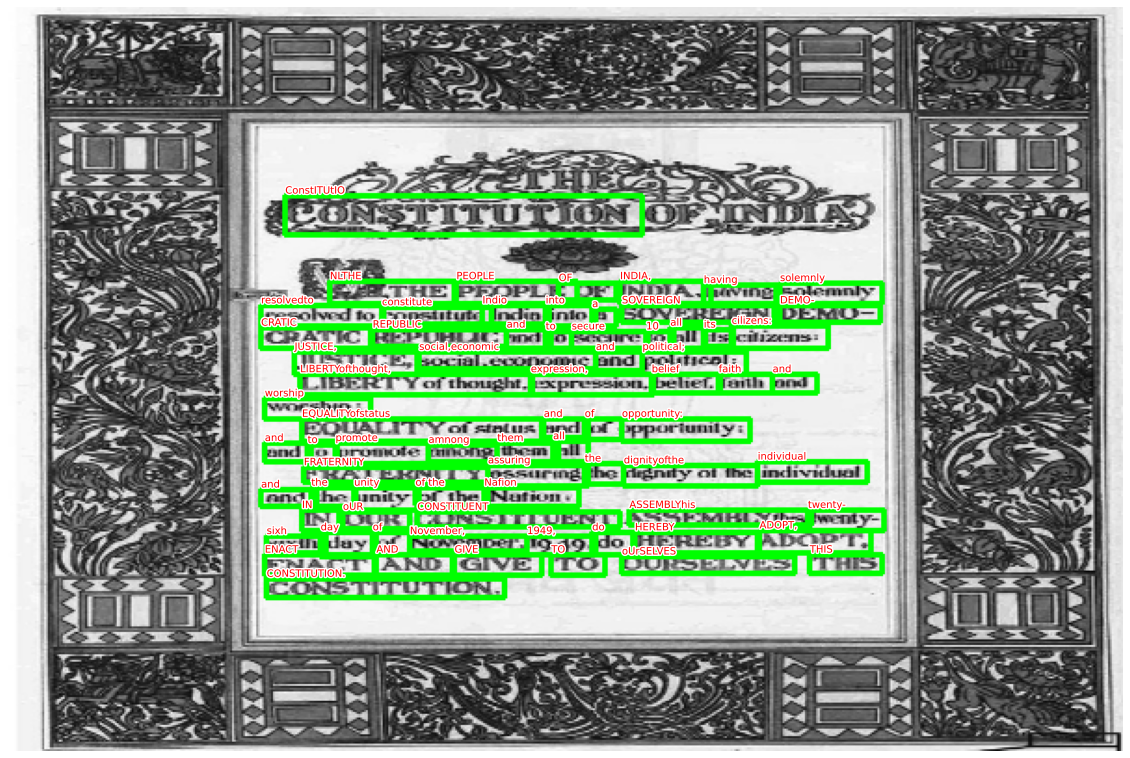

text  block_id                                                 bb
0  ConstITUtIO         0  [0.24833333333333332, 0.2525, 0.56833333333333...
1        NLTHE         1         [0.28833333333333333, 0.3675, 0.4, 0.3975]
2       PEOPLE         1        [0.40166666666666667, 0.3675, 0.51, 0.3975]
3           OF         1         [0.49333333333333335, 0.37, 0.545, 0.3925]
4       INDIA,         1         [0.5483333333333333, 0.3675, 0.63, 0.3975]

In [11]:
#| hide
df = DF.copy()
im = IM.copy()
df = combine_xyXY_to_bb(df)
im, df = rescale(im, df, (400, 600))
show(im, df=df, sz=20)
df.head()

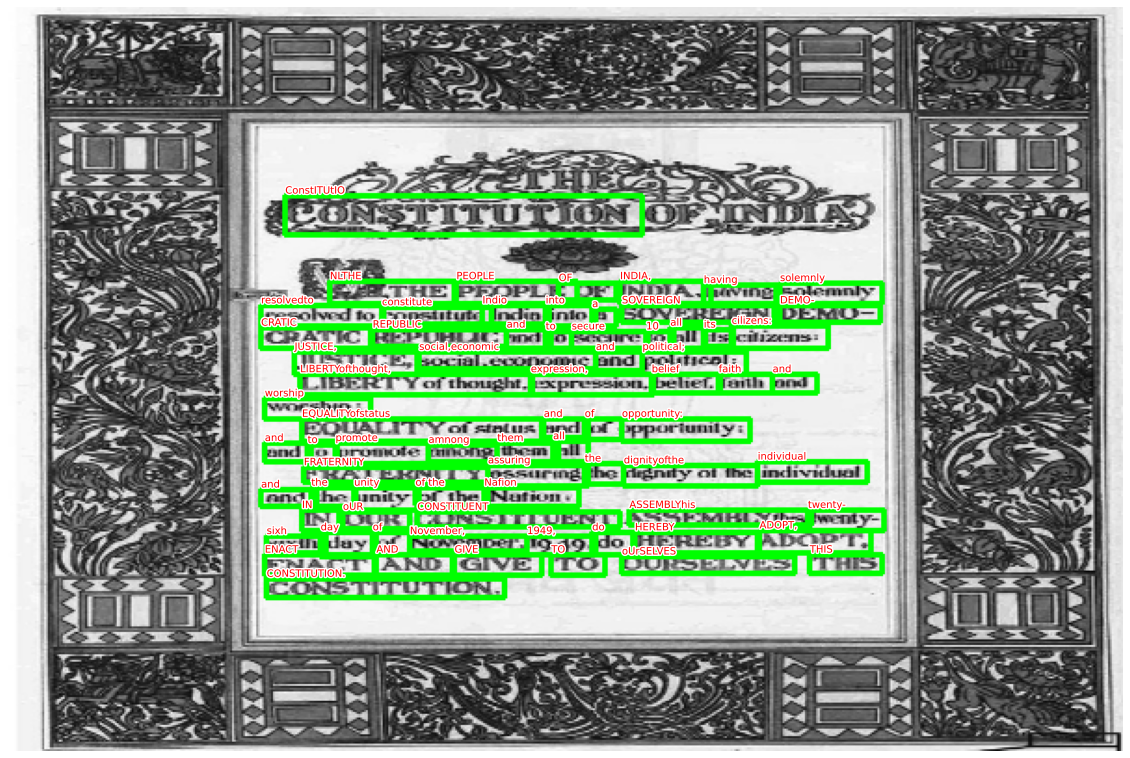

text  block_id                    bb
0  ConstITUtIO         0  [149, 101, 341, 122]
1        NLTHE         1  [173, 147, 240, 159]
2       PEOPLE         1  [241, 147, 306, 159]
3           OF         1  [296, 148, 327, 157]
4       INDIA,         1  [329, 147, 378, 159]

In [12]:
#| hide
df = DF.copy()
im = IM.copy()
df = to_absolute(df, *im.shape)
df = combine_xyXY_to_bb(df)
im, df = rescale(im, df, (400, 600))
show(im, df=df, sz=20)
df.head()

## Rotate

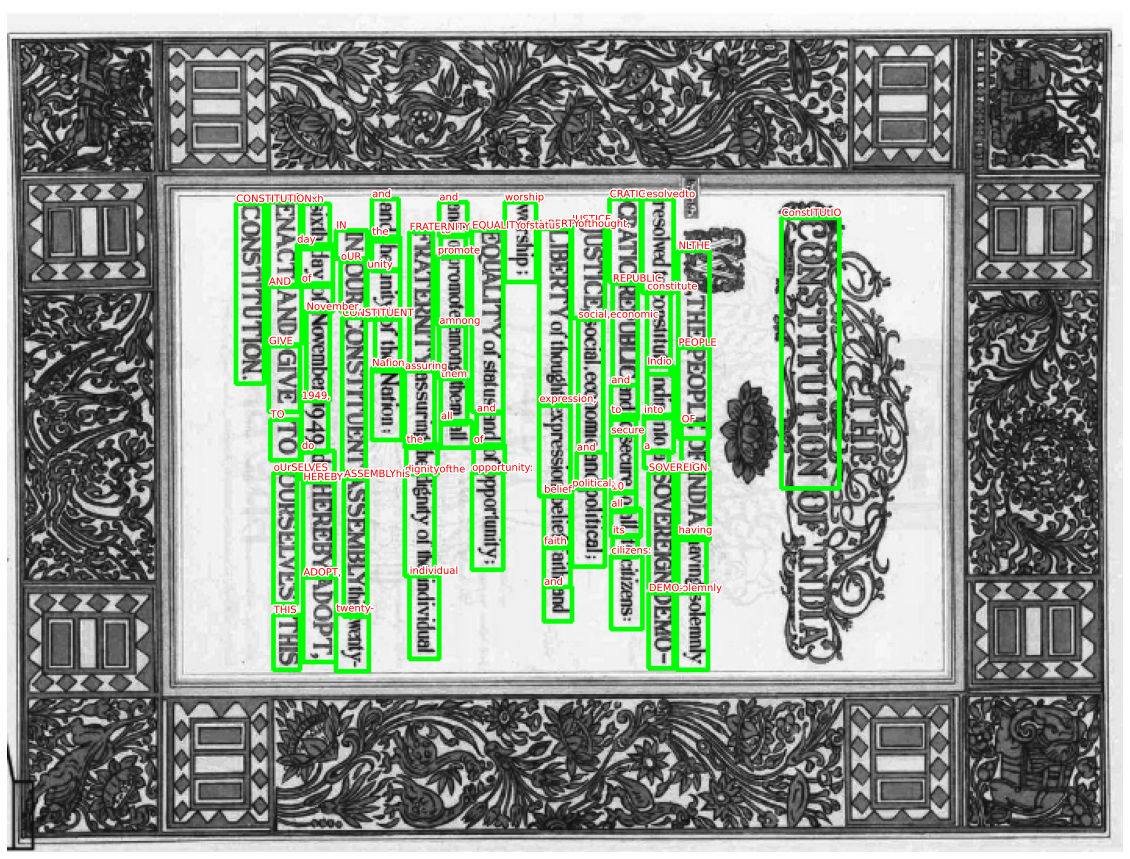

<class 'numpy.ndarray'>


text  block_id         x         y         X         Y
0  ConstITUtIO         0  0.693277  0.249538  0.745098  0.569316
1        NLTHE         1  0.600840  0.288355  0.628852  0.401109
2       PEOPLE         1  0.600840  0.402957  0.628852  0.510166
3           OF         1  0.603641  0.493530  0.627451  0.545287
4       INDIA,         1  0.600840  0.548983  0.628852  0.630314

In [13]:
df = DF.copy()
im = IM.copy()
im, df = rotate(im, df, 90)
show(im, df=df, sz=20)
print(type(im))
df.head()

## Pad

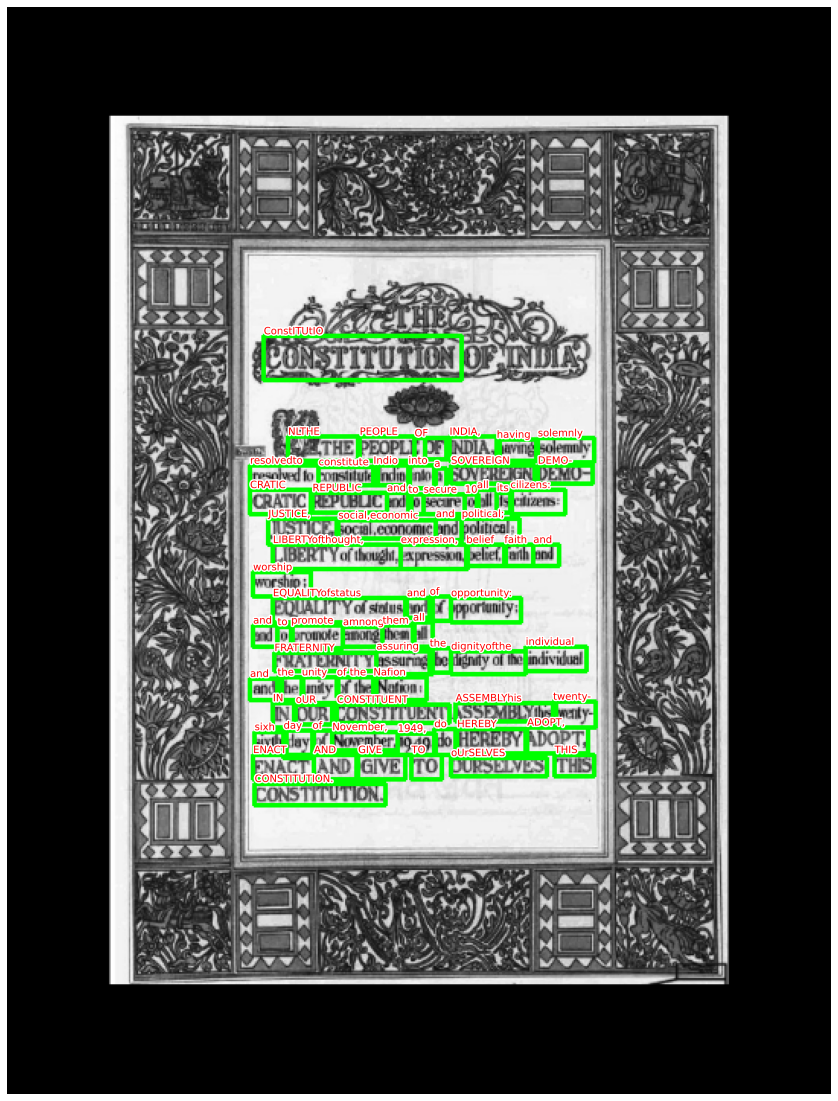

<class 'numpy.ndarray'>


text  block_id         x         y         X         Y
0  ConstITUtIO         0  0.310536  0.302521  0.550832  0.343137
1        NLTHE         1  0.340111  0.394958  0.425139  0.417367
2       PEOPLE         1  0.426987  0.394958  0.506470  0.417367
3           OF         1  0.493530  0.396359  0.532348  0.415966
4       INDIA,         1  0.536044  0.394958  0.597043  0.417367

In [14]:
df = DF.copy()
im = IM.copy()
im, df = pad(im, df, deltas=(90, 90), cval=0)
show(im, df=df, sz=20)
print(type(im))
df.head()

## Augmentations as Monads
All functions will work with data frames **that contain either of absolute/relative coordinates**, and will preserve the image type (`np.ndarray` or `PIL.Image.Image`) too

x         y         X         Y         text  block_id
0  0.249538  0.253501  0.569316  0.305322  ConstITUtIO         0
1  0.288355  0.369748  0.401109  0.397759        NLTHE         1
2  0.402957  0.369748  0.510166  0.397759       PEOPLE         1
3  0.493530  0.371148  0.545287  0.394958           OF         1
4  0.548983  0.369748  0.630314  0.397759       INDIA,         1

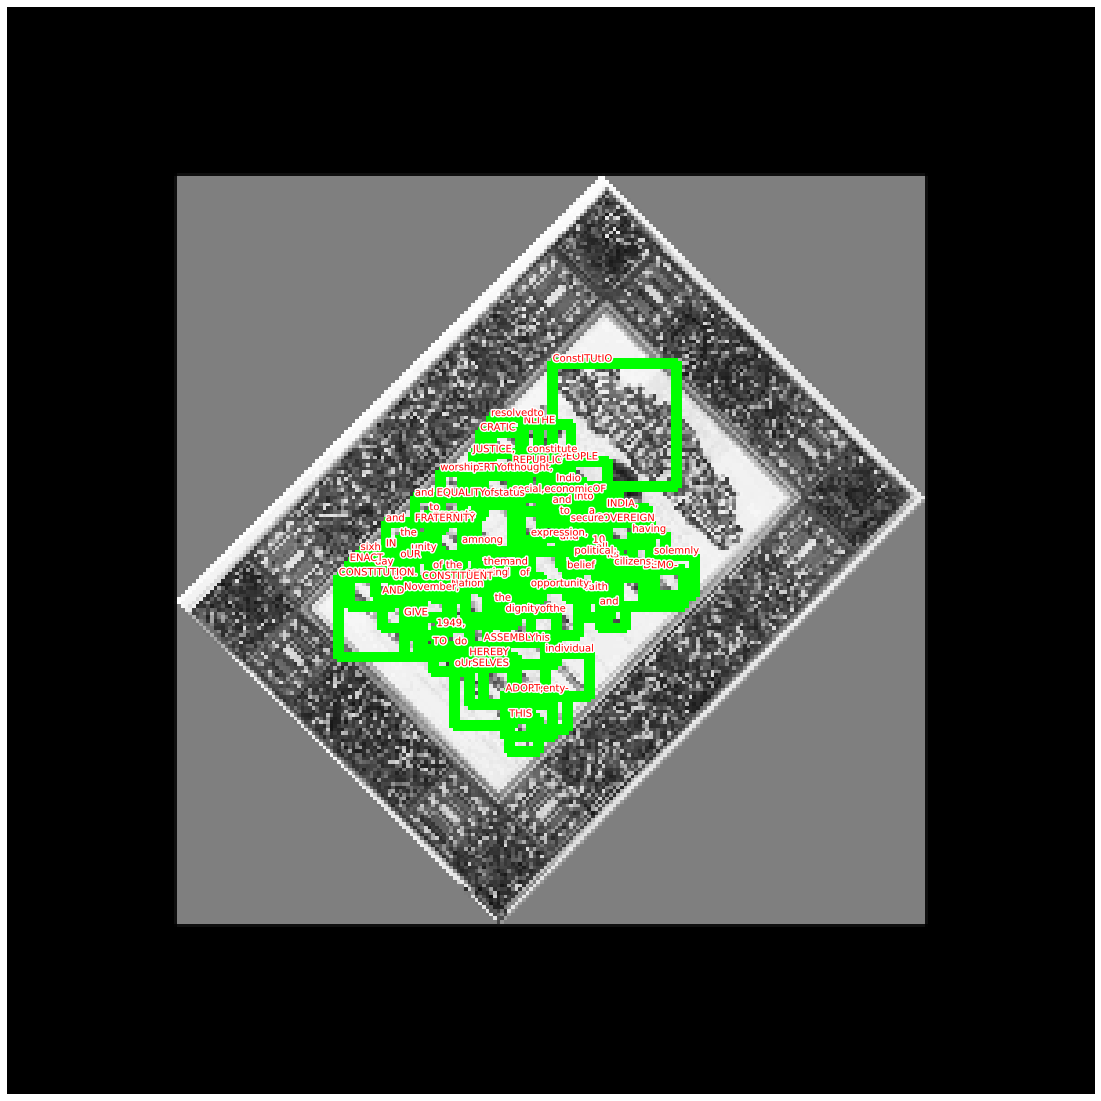

<class 'PIL.Image.Image'>


text  block_id         x         y         X         Y
0  ConstITUtIO         0  0.500000  0.326667  0.613333  0.440000
1        NLTHE         1  0.473333  0.383333  0.516667  0.426667
2       PEOPLE         1  0.506667  0.416667  0.550000  0.460000
3           OF         1  0.536667  0.446667  0.560000  0.470000
4       INDIA,         1  0.550000  0.460000  0.586667  0.493333

In [15]:
df = DF.copy()
im = IM.copy()
height, width = im.shape
show(df.head())
im = PIL.Image.fromarray(im)
im, df = rotate(im, df, 45, cval=127)
im, df = pad(im, df, deltas=(200, 200), cval=0)
im, df = rescale(im, df, sz=(300, 300))
show(im, df=df, sz=20)
print(type(im))
df.head()